# Modelo 1: recomendação de ofertas

## *Etapa 1: Modelo Supervisionado*

Esta etapa inclui o treinamento do modelo supervisionado que tem como resultado a propensão de compra de um tipo de oferta $P(offerType)$ 
assim como  a propensão de compra de uma oferta condicionada ao tipo de oferta $P(offer | offerType)$ 


TEOREMA DE BAYES

$$P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}$$

PARA -> 
A = offer,
B = offer_type

$$P(offer | offerType) = \frac{P(offerType | offer) \times P(offer)}{P(offerType)}$$

$$P(offer | offerType) \times P(offerType) = P(offerType | offer) \times P(offer)$$

$$P(offer) = \frac{P(offer | offerType) \times P(offerType)}{P(offerType | offer)}$$


$$P(offerType | offer) = 1$$

SOLUÇÂO:
$$P(offer) = P(offer | offerType) \times P(offerType)$$

$P(offer | offerType) =>$ Solução Frequentista

$P(offerType) =>$ Modelo Supervisionado

## *Etapa 2: Cluster de Clientes*
Esta etapa inclui a criação de cluster de clientes com base em suas informações demograficas

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PySparkTest').getOrCreate()

from IPython.display import display, HTML
display(HTML("<style>.jp-Cell-outputArea { text-align: center; }</style>"))

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/10 15:57:20 WARN Utils: Your hostname, N0L144853, resolves to a loopback address: 127.0.1.1; using 192.168.3.112 instead (on interface wlp0s20f3)
25/08/10 15:57:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/10 15:57:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/08/10 15:57:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/08/10 15:57:21 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/08/10 15:57:21 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/08/10 15:57:21 WARN Utils

In [2]:
import plotly.express as px
from pyspark.sql import types as T
from pyspark.sql.window import Window
from pyspark.sql import functions as F

def metrics_at(df, tresh):
    TN = df.where(f"y_proba_class1 < {tresh} AND target=0").count()
    FN = df.where(f"y_proba_class1 < {tresh} AND target=1").count()
    FP = df.where(f"y_proba_class1 >= {tresh} AND target=0").count()
    TP = df.where(f"y_proba_class1 >= {tresh} AND target=1").count()

    precision = TP / (TP + FP) if (TP + FP)>0 else 0.0
    recall = TP / (TP + FN) if (TP + FN)>0 else 0.0
    f1 = (2*precision*recall)/(precision+recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1, TP, FP, TN, FN

def optimize_threshold(df):
    qs = [i/100 for i in range(5, 96)]
    thresholds = df.approxQuantile("y_proba_class1", qs, 0.001)

    best = (None, -1.0) 
    for t in thresholds:
        p,r,f1,TP,FP,TN,FN = metrics_at(df, t)
        if f1 > best[1]:
            best = (t, f1)
    best_t = best[0]

    return best_t

SPLIT_TRAIN = 0.8
NUM_TREES = 200
MAX_DEPTH = 10
MAX_BINS = 80

# Read Files

In [3]:
path_mastertable = '../data/trusted/mastertable'

df_merge = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_mastertable)

# Modeling

In [5]:
aux = df_merge.select("client_id", 'offer_id', "qtd_offer_received", 'qtd_offer_completed', 'offer_type')\
              .groupBy("client_id", 'offer_type')\
              .agg(F.sum("qtd_offer_received").alias("offer_type_count"))

aux.show(5, truncate=False)

+--------------------------------+-------------+----------------+
|client_id                       |offer_type   |offer_type_count|
+--------------------------------+-------------+----------------+
|00bc983061d3471e8c8e74d31b7c8b6f|discount     |2               |
|0222d267445f4f078bc325224e471766|bogo         |2               |
|03118ab70a404fada1a433cd6abaa491|bogo         |1               |
|033d0a511a5c452ea2be37a23f8c6dcb|informational|2               |
|072731be403a472883bed6c38a8e7aa8|bogo         |1               |
+--------------------------------+-------------+----------------+
only showing top 5 rows


In [6]:
df_freq_bayes = df_merge.select("client_id", 'offer_id', 'qtd_offer_completed', 'offer_type')\
                        .join(aux, on=['client_id', 'offer_type'], how='left')\
                        .select("client_id", "offer_type", "offer_id", "qtd_offer_completed", "offer_type_count")\
                        .withColumn("freq_bayes", F.when(F.col("offer_type_count")!=0, F.col("qtd_offer_completed")/F.col("offer_type_count")).otherwise(0))\
                        .orderBy("client_id", 'offer_id')
df_freq_bayes.show(truncate=False)

+--------------------------------+-------------+--------------------------------+-------------------+----------------+------------------+
|client_id                       |offer_type   |offer_id                        |qtd_offer_completed|offer_type_count|freq_bayes        |
+--------------------------------+-------------+--------------------------------+-------------------+----------------+------------------+
|0009655768c64bdeb2e877511632db8f|discount     |2906b810c7d4411798c6938adc9daaa5|1                  |2               |0.5               |
|0009655768c64bdeb2e877511632db8f|informational|3f207df678b143eea3cee63160fa8bed|0                  |2               |0.0               |
|0009655768c64bdeb2e877511632db8f|informational|5a8bc65990b245e5a138643cd4eb9837|0                  |2               |0.0               |
|0009655768c64bdeb2e877511632db8f|bogo         |f19421c1d4aa40978ebb69ca19b0e20d|1                  |1               |1.0               |
|0009655768c64bdeb2e877511632db8f|

In [7]:
df_freq_bayes.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_freq_bayes.columns]).show()

+---------+----------+--------+-------------------+----------------+----------+
|client_id|offer_type|offer_id|qtd_offer_completed|offer_type_count|freq_bayes|
+---------+----------+--------+-------------------+----------------+----------+
|        0|         0|       0|                  0|               0|         0|
+---------+----------+--------+-------------------+----------------+----------+



In [8]:
df_freq_bayes.write.format("parquet").mode("overwrite").save('../data/trusted/freq_bayes')

## Select Features

In [9]:
df_features = df_merge.select('client_id', 'offer_id', 'offer_type_index', 'qtd_offer_received', 'qtd_offer_viewed', 'qtd_offer_completed', 'sum_reward', 
                              'registered_duration_month', 'registered_duration_years', 'gender_M', 'gender_F', 'gender_O','gender_U', 'age_group_index', 
                              'credit_card_limit', 'category_limite', 'offer_min_value', 'offer_discount_value', 'offer_duration', 'qtd_transaction', 
                              'total_amount', 'avg_amount')\
                        .withColumn('target', F.when(F.col('qtd_offer_completed')>0, 1).otherwise(0))\
                        .drop('qtd_offer_completed')
df_features.show(5, truncate=False)

+--------------------------------+--------------------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------+----------+------+
|client_id                       |offer_id                        |offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|total_amount|avg_amount|target|
+--------------------------------+--------------------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------

In [10]:
df_features.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|28996|
|     0|34292|
+------+-----+



## Create RandomForestModel

In [11]:
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [12]:
features = ['offer_type_index',  'offer_min_value', 'offer_discount_value', 'offer_duration', 'gender_M', 
            'gender_F', 'gender_O', 'gender_U', 'age_group_index','category_limite', 'registered_duration_month',
            'registered_duration_years', 'qtd_transaction', 'total_amount', 'avg_amount']

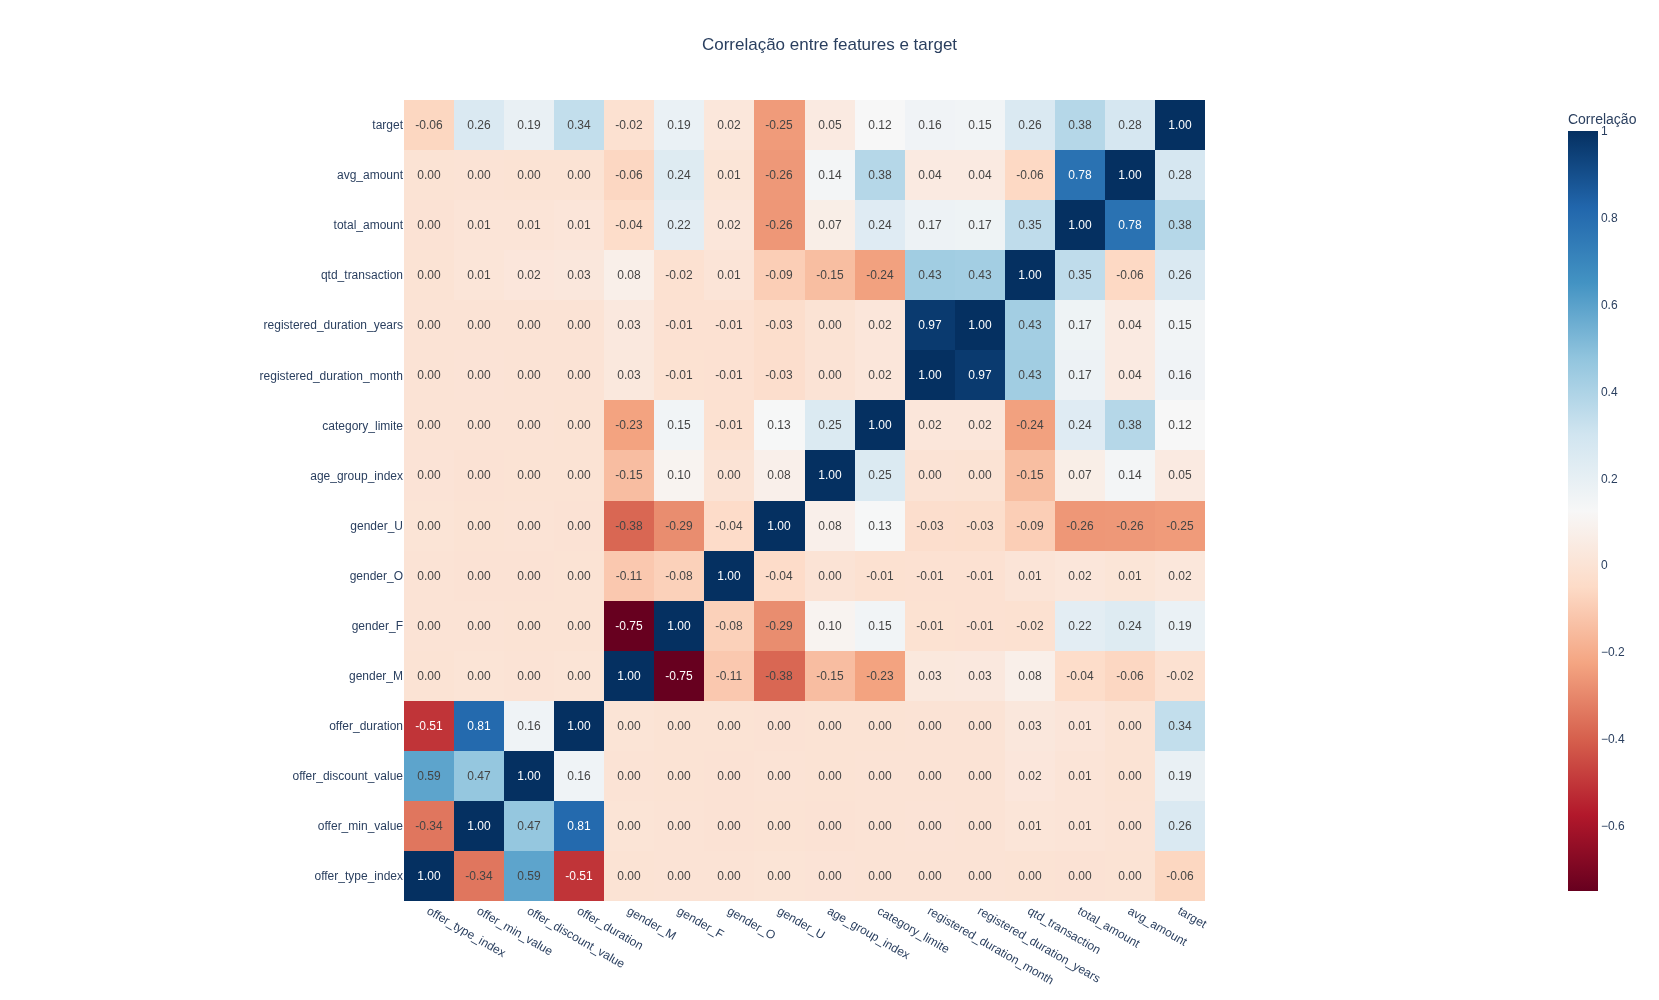

In [13]:
correlation_matrix = df_features[features + ['target']].toPandas().corr()

fig = px.imshow(
    correlation_matrix,
    text_auto=".2f",           
    color_continuous_scale="RdBu",  
    origin="lower",
    title="Correlação entre features e target"
)

fig.update_layout(
    width=1500,
    height=1000,
    title=dict(x=0.5, xanchor="center"), 
    coloraxis_colorbar=dict(title="Correlação")
)

fig.show()

### Train Model

In [14]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features = assembler.transform(df_features)

train_df, test_df = df_features.randomSplit([SPLIT_TRAIN, 1-SPLIT_TRAIN], seed=42)

In [15]:
df_features.count(), train_df.count()+test_df.count()

(63288, 63288)

In [16]:
rf = RandomForestClassifier(labelCol="target", 
                            featuresCol="features", 
                            numTrees=NUM_TREES, 
                            maxDepth=MAX_DEPTH, 
                            maxBins=MAX_BINS
                        )
model = rf.fit(train_df)

25/08/10 15:58:08 WARN DAGScheduler: Broadcasting large task binary with size 1158.0 KiB
25/08/10 15:58:10 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/08/10 15:58:13 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/08/10 15:58:16 WARN DAGScheduler: Broadcasting large task binary with size 1096.7 KiB
25/08/10 15:58:17 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/08/10 15:58:21 WARN DAGScheduler: Broadcasting large task binary with size 1914.3 KiB
25/08/10 15:58:22 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
25/08/10 15:58:27 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


In [17]:
pred = model.transform(test_df)

In [18]:
pred = pred.withColumn("prob_vec", vector_to_array(F.col("probability")))\
           .withColumn("y_proba_class0", F.col("prob_vec")[0])\
           .withColumn("y_proba_class1", F.col("prob_vec")[1])

In [19]:
conf_matrix_df = pred.select("target", "prediction")\
                     .crosstab("target", "prediction").fillna(0)
conf_matrix_df.show()

25/08/10 15:59:07 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:08 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:09 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:09 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:09 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:10 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


+-----------------+----+----+
|target_prediction| 0.0| 1.0|
+-----------------+----+----+
|                0|5972| 986|
|                1| 613|5242|
+-----------------+----+----+



25/08/10 15:59:11 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


##### Podemos melhorar um pouco esses Falsos Negativo encontrando um melhor ponto de corte (Temos que ter atenção, pois mudar isso vai depender do negócio, em outras palavras, da estratégia de negócio)
 - Vale a pena pro negócio enviar mais ofertas que tenham uma baixa probabilidade de aceitação sabendo que vamos capturar mais clientes com alta probabilidade de aceitação?

##### Procurando melhor Tresh para a base de Teste

In [20]:
pred_probs = pred.select('y_proba_class1', 'target')
test_best_tresh = optimize_threshold(pred_probs)

print(f"Melhor threshold por F1: {test_best_tresh:.3f}")

25/08/10 15:59:20 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:20 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:21 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:22 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:23 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:24 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:24 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:25 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:26 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:27 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:28 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 15:59:28 WARN DAGScheduler: Broadcasting larg

Melhor threshold por F1: 0.433


In [21]:
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred.select('y_proba_class1', 'target'), test_best_tresh)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/10 16:04:07 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:08 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:09 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:09 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


5801 1157 465 5390
precision: 0.82328
recall: 0.92058
f1: 0.86921


### Predict Dataset

In [22]:
df_base = assembler.transform(df_features.drop('features'))

preds_base = model.transform(df_base)

preds_base = preds_base.withColumn("prob_vec", vector_to_array(F.col("probability")))\
                       .withColumn("y_proba_class0", F.col("prob_vec")[0])\
                       .withColumn("y_proba_class1", F.col("prob_vec")[1])

In [23]:
preds_base.show()

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------------+------------------+------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|      total_amount|        avg_amount|target|            features|       rawPrediction|         probability|prediction|            prob_vec|      y_proba_class0|      y_proba_class1|
+-------

25/08/10 16:04:29 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


In [24]:
conf_matrix_df = preds_base.select("target", "prediction")\
                           .crosstab("target", "prediction").fillna(0)
conf_matrix_df.show()

25/08/10 16:04:34 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:35 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:35 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:36 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:36 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:38 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


+-----------------+-----+-----+
|target_prediction|  0.0|  1.0|
+-----------------+-----+-----+
|                0|29644| 4648|
|                1| 2795|26201|
+-----------------+-----+-----+



25/08/10 16:04:38 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


##### Verificando precision, recall e f1 para a base toda com o Tresh padrão

In [25]:
pred_probs = preds_base.select('y_proba_class1', 'target')
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred_probs, 0.5)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/10 16:04:44 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:46 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:47 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:49 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


29644 4648 2795 26201
precision: 0.84933
recall: 0.90361
f1: 0.87563


##### Verificando precision, recall e f1 para a base toda com o melhor Tresh da base de Teste

In [26]:
pred_probs = preds_base.select('y_proba_class1', 'target')
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred_probs, test_best_tresh)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/10 16:04:54 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:56 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:58 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:04:59 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


28815 5477 2102 26894
precision: 0.83081
recall: 0.92751
f1: 0.87650


##### Procurando melhor Tresh quando considerado toda a base

In [27]:
pred_probs = preds_base.select('y_proba_class1', 'target')
dataset_best_tresh = optimize_threshold(pred_probs)

print(f"Melhor threshold por F1: {dataset_best_tresh:.3f}")

25/08/10 16:05:09 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:10 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:12 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:14 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:15 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:17 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:19 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:20 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:24 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:25 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:05:27 WARN DAGScheduler: Broadcasting larg

Melhor threshold por F1: 0.436


In [28]:
pred_probs = preds_base.select('y_proba_class1', 'target')
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred_probs, dataset_best_tresh)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/10 16:15:13 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:15:15 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:15:17 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/08/10 16:15:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


28855 5437 2139 26857
precision: 0.83164
recall: 0.92623
f1: 0.87639


In [31]:
preds_base.count(), df_features.count()

(63288, 63288)

In [32]:
preds_base.show(5)

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------+----------+------+--------------------+--------------------+--------------------+----------+--------------------+-------------------+------------------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|total_amount|avg_amount|target|            features|       rawPrediction|         probability|prediction|            prob_vec|     y_proba_class0|    y_proba_class1|
+--------------------+--------------------

25/08/10 16:37:56 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


In [31]:
preds_base.write.format("parquet").mode("overwrite").save('../data/trusted/rf_output_model')

## Create KMeansModel

In [33]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [34]:
features = ['registered_duration_month', 'registered_duration_years', 'gender_M', 'gender_F', 'gender_O','gender_U', 'age_group_index', 
            'credit_card_limit', 'category_limite', 'qtd_transaction', 'total_amount', 'avg_amount']

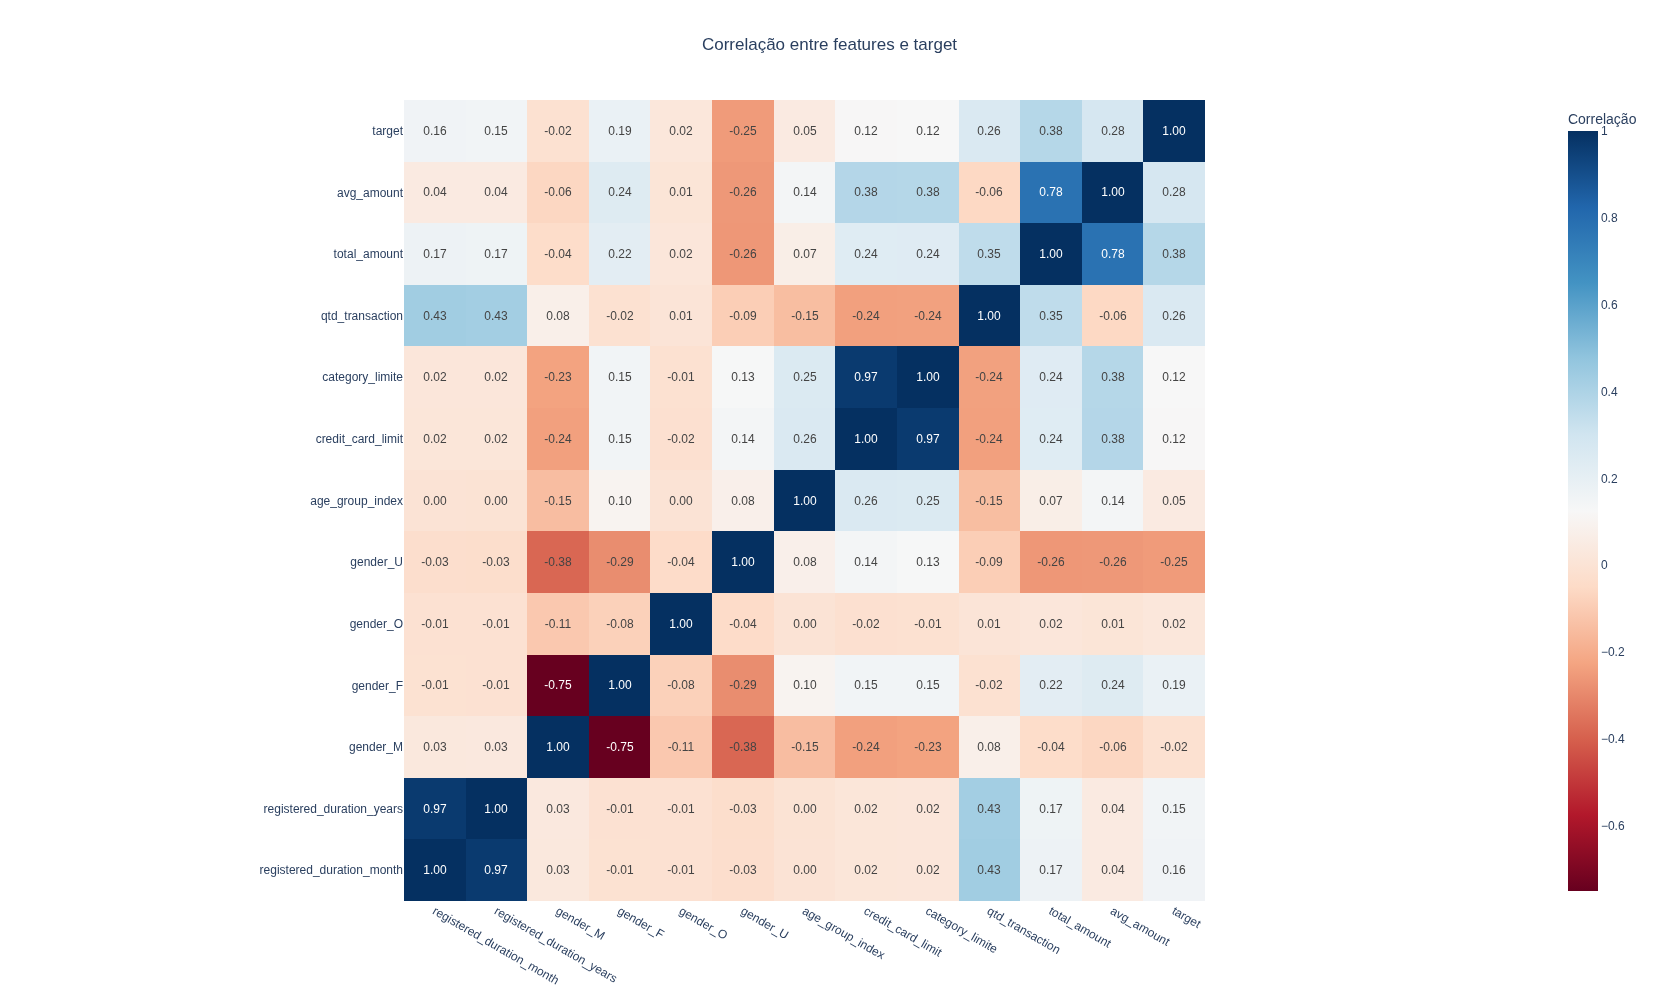

In [35]:
correlation_matrix = df_features[features + ['target']].toPandas().corr()

fig = px.imshow(
    correlation_matrix,
    text_auto=".2f",           
    color_continuous_scale="RdBu",  
    origin="lower",
    title="Correlação entre features e target"
)

fig.update_layout(
    width=1500,
    height=1000,
    title=dict(x=0.5, xanchor="center"), 
    coloraxis_colorbar=dict(title="Correlação")
)

fig.show()

In [36]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features_kmeans = assembler.transform(df_features.drop('features'))

In [37]:
scaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=True)
df_features_kmeans = scaler.fit(df_features_kmeans).transform(df_features_kmeans)

In [38]:
df_features_kmeans.show(5)

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------+----------+------+--------------------+--------------------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|total_amount|avg_amount|target|            features|     features_scaled|
+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+---------------

In [39]:
kmeans = KMeans(featuresCol="features_scaled", predictionCol="cluster", k=5, seed=42)
model_kmeans = kmeans.fit(df_features_kmeans)

In [40]:
df_clusters = model_kmeans.transform(df_features_kmeans)

In [41]:
df_clusters.show()

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------------+------------------+------+--------------------+--------------------+-------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|      total_amount|        avg_amount|target|            features|     features_scaled|cluster|
+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+-----

In [306]:
df_clusters.write.format("parquet").mode("overwrite").save('../data/trusted/km_output_model')